# 🎯 White-Box Uncertainty Quantification

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
     White-box Uncertainty Quantification (UQ) methods leverage token probabilities to estimate uncertainty. Multi-generation white-box methods generate multiple responses from the same prompt, combining the sampling approach of black-box UQ with token-probability-based singals. This demo provides an illustration of how to use state-of-the-art white-box UQ methods with <code>uqlm</code>. The following multi-generation scorers are available:
  </p>
      
*   Monte carlo sequence probability ([Kuhn et al., 2023](https://arxiv.org/abs/2302.09664))
*   Consistency and Confidence (CoCoA) ([Vashurin et al., 2025](https://arxiv.org/abs/2502.04964))
*   Semantic Negentropy ([Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0)) 
*   Semantic Density ([Qiu et al., 2024](https://arxiv.org/abs/2405.13845))
</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate and score LLM responses to the example questions using the <code>WhiteBoxUQ()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Visualize model accuracy at different thresholds of the various white-box UQ confidence scores. Compute precision, recall, and F1-score of hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Robust Uncertainty Signals:</strong> Leverages token probabilities from multiple sampled responses.</li>
      <li><strong>SOTA Performance:</strong> Enables use of top SOTA methods, including Semantic Entropy and Semantic Density.</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Limited Compatibility:</strong> Requires access to token probabilities, not available for all LLMs/APIs.</li>
      <li><strong>Higher Cost:</strong> Requires multiple generations per prompt</li>
      <li><strong>Slower:</strong> Multiple generations and comparison calculations increase latency</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm import WhiteBoxUQ
from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner

<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using a set of math questions from the [gsm8k benchmark](https://github.com/openai/grade-school-math). To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (gsm8k)
gsm8k = load_example_dataset("gsm8k", n=100)
gsm8k.head()

Loading dataset - gsm8k...
Processing dataset...
Dataset ready!


,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,72
1,Weng earns $12 an hour for babysitting. Yester...,10
2,Betty is saving money for a new wallet which c...,5
3,"Julie is reading a 120-page book. Yesterday, s...",42
4,James writes a 3-page letter to 2 different fr...,624


In [3]:
# Define prompts
MATH_INSTRUCTION = "When you solve this math problem only return the answer with no additional text.\n"
prompts = [MATH_INSTRUCTION + prompt for prompt in gsm8k.question]

In this example, we use `AzureChatOpenAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [4]:
# import os
# import sys
# !{sys.executable} -m pip install python-dotenv
# !{sys.executable} -m pip install langchain-openai

# # User to populate .env file with API credentials. In this step, replace with your LLM of choice.
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
llm = AzureChatOpenAI(deployment_name="gpt-4o", openai_api_type="azure", openai_api_version="2024-02-15-preview", temperature=1)

<a id='section2'></a>
## 2. Generate responses and confidence scores

### `WhiteBoxUQ()` - Generate LLM responses and compute token-probability-based confidence scores for each response.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/white_box_graphic.png)

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of their `llm` object.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">scorers</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">List[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which white-box (token-probability-based) scorers to include. Must be subset of {"normalized_probability", "min_probability", "sequence_probability", "max_token_negentropy", "mean_token_negentropy", "probability_margin", "monte_carlo_probability", "consistency_and_confidence"}. If None, defaults to ["normalized_probability", "min_probability"].</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">sampling_temperature</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">float<br><code>default=1</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">The 'temperature' parameter for LLM to use when generating sampled LLM responses. Must be greater than 0.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 Model-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
      <li><code>sampling_temperature</code></li>       
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>scorers</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
    </ul>
  </div>
</div>

In [5]:
wbuq = WhiteBoxUQ(
    llm=llm, 
    scorers=[
        "monte_carlo_probability", # requires multiple sampled responses per prompt
        "consistency_and_confidence", # requires multiple sampled responses per prompt
        "p_true" # generates one additional response per prompt, acts as logprobs-based self-judge
    ],
    max_calls_per_min=125,
)

### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">WhiteBoxUQ.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses and compute confidence scores for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>List[str] or List[List[BaseMessage]]</strong>) A list of input prompts for the model.</li>
        <li><code>num_responses</code> - (<strong>int, default=5</strong>) The number of sampled responses used to compute consistency.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, log probabilities, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Compute confidence scores on provided LLM responses and logprobs. Should only be used if responses and sampled responses are already generated with logprobs.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>responses</code> - (<strong>List[str]</strong>) A list of LLM responses for the prompts.</li>
        <li><code>logprob_results</code> - (<strong>List[List[str]]</strong>) A list of dictionaries, each returned by BaseChatModel.agenerate corresponding to <code>responses</code>.</li>
        <li><code>sampled_responses</code> - (<strong>List[List[str]], default=None</strong>) A list of lists of sampled LLM responses for each prompt. Used to compute consistency scores by comparing to the corresponding response from <code>responses</code>. Required only for "monte_carlo_probability" and "consistency_and_confidence" scorers.</li>
        <li><code>sampled_logprob_results</code> - (<strong>List[List[str]], default=None</strong>) List of list of dictionaries, each returned by BaseChatModel.agenerate. These must correspond to <code>sampled_responses</code>. Required only for "monte_carlo_probability" and "consistency_and_confidence" scorers.</li>
        <li><code>prompts</code> - (<strong>List[List[str]], default=None</strong>) List of prompts from which <code>responses</code> were generated. Required only for "p_true" scorer.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses and logprobs are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [6]:
results = await wbuq.generate_and_score(prompts=prompts, num_responses=5)

Output()

Output()

In [7]:
result_df = results.to_df()
result_df.head()

,prompt,response,logprobs_result,sampled_responses,sampled_logprobs_result,monte_carlo_probability,consistency_and_confidence,p_true
0,When you solve this math problem only return t...,72,"[{'token': '72', 'bytes': [55, 50], 'logprob':...","[72, 72, 72, 72, 72]","[[{'token': '72', 'bytes': [55, 50], 'logprob'...",0.994454,0.977019,0.679163
1,When you solve this math problem only return t...,$10,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...","[$10, $10, $10, $10, $10]","[[{'token': '$', 'bytes': [36], 'logprob': -0....",0.997482,0.999759,0.022983
2,When you solve this math problem only return t...,$20,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...","[$20, $20, $20, $10, $20]","[[{'token': '$', 'bytes': [36], 'logprob': -0....",0.811558,0.910326,0.095358
3,When you solve this math problem only return t...,48,"[{'token': '48', 'bytes': [52, 56], 'logprob':...","[48, 48, 48, 48, 48]","[[{'token': '48', 'bytes': [52, 56], 'logprob'...",0.996287,0.996571,0.268947
4,When you solve this math problem only return t...,624,"[{'token': '624', 'bytes': [54, 50, 52], 'logp...","[624, 624, 624, 624, 624]","[[{'token': '624', 'bytes': [54, 50, 52], 'log...",0.999912,0.999848,0.499997


<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the responses against an answer key. Note the `math_postprocessor` is specific to our use case (math questions). **If you are using your own prompts/questions, update the grading method accordingly**.

In [8]:
# Populate correct answers
result_df["answer"] = gsm8k.answer

# Grade responses against correct answers
result_df["response_correct"] = [math_postprocessor(r) == a for r, a in zip(result_df["response"], gsm8k["answer"])]
result_df.head(5)

,prompt,response,logprobs_result,sampled_responses,sampled_logprobs_result,monte_carlo_probability,consistency_and_confidence,p_true,answer,response_correct
0,When you solve this math problem only return t...,72,"[{'token': '72', 'bytes': [55, 50], 'logprob':...","[72, 72, 72, 72, 72]","[[{'token': '72', 'bytes': [55, 50], 'logprob'...",0.994454,0.977019,0.679163,72,True
1,When you solve this math problem only return t...,$10,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...","[$10, $10, $10, $10, $10]","[[{'token': '$', 'bytes': [36], 'logprob': -0....",0.997482,0.999759,0.022983,10,True
2,When you solve this math problem only return t...,$20,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...","[$20, $20, $20, $10, $20]","[[{'token': '$', 'bytes': [36], 'logprob': -0....",0.811558,0.910326,0.095358,5,False
3,When you solve this math problem only return t...,48,"[{'token': '48', 'bytes': [52, 56], 'logprob':...","[48, 48, 48, 48, 48]","[[{'token': '48', 'bytes': [52, 56], 'logprob'...",0.996287,0.996571,0.268947,42,False
4,When you solve this math problem only return t...,624,"[{'token': '624', 'bytes': [54, 50, 52], 'logp...","[624, 624, 624, 624, 624]","[[{'token': '624', 'bytes': [54, 50, 52], 'log...",0.999912,0.999848,0.499997,624,True


In [9]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.51


#### 3.1 Filtered LLM Accuracy Evaluation

Here, we explore ‘filtered accuracy’ as a metric for evaluating the performance of our confidence scores. Filtered accuracy measures the change in LLM performance when responses with confidence scores below a specified threshold are excluded. By adjusting the confidence score threshold, we can observe how the accuracy of the LLM improves as less certain responses are filtered out.

We will plot the filtered accuracy across various confidence score thresholds to visualize the relationship between confidence and LLM accuracy. This analysis helps in understanding the trade-off between response coverage (measured by sample size below) and LLM accuracy, providing insights into the reliability of the LLM’s outputs. We conduct this analysis separately for each of our scorers. 

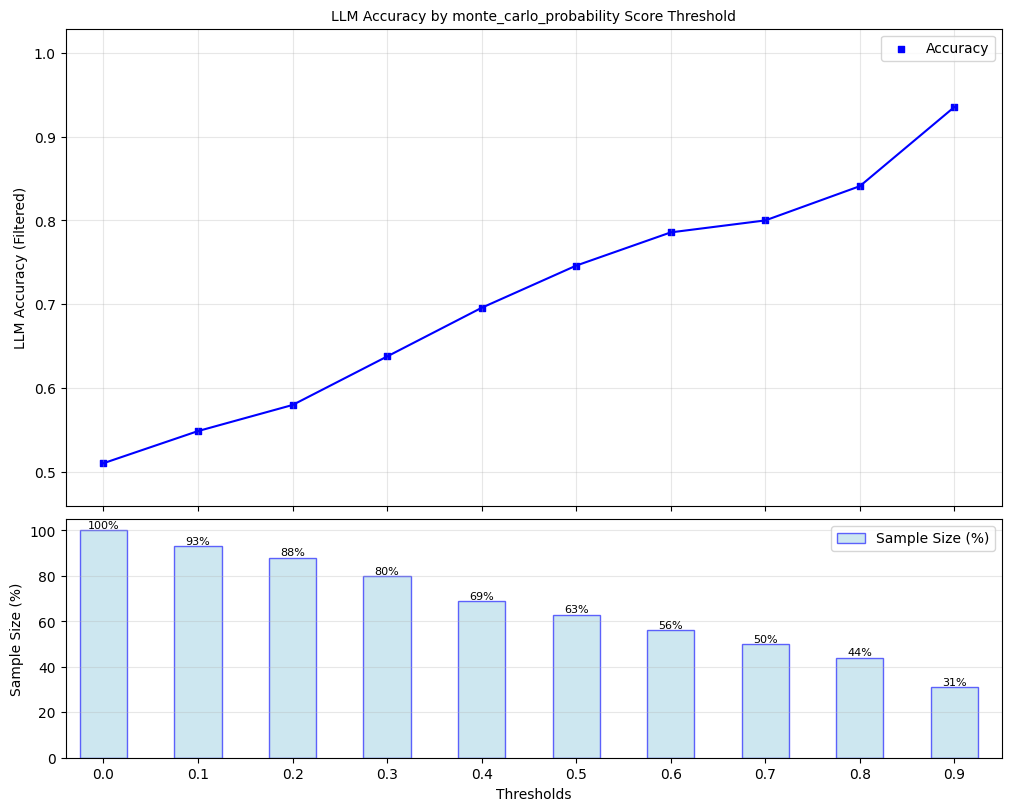

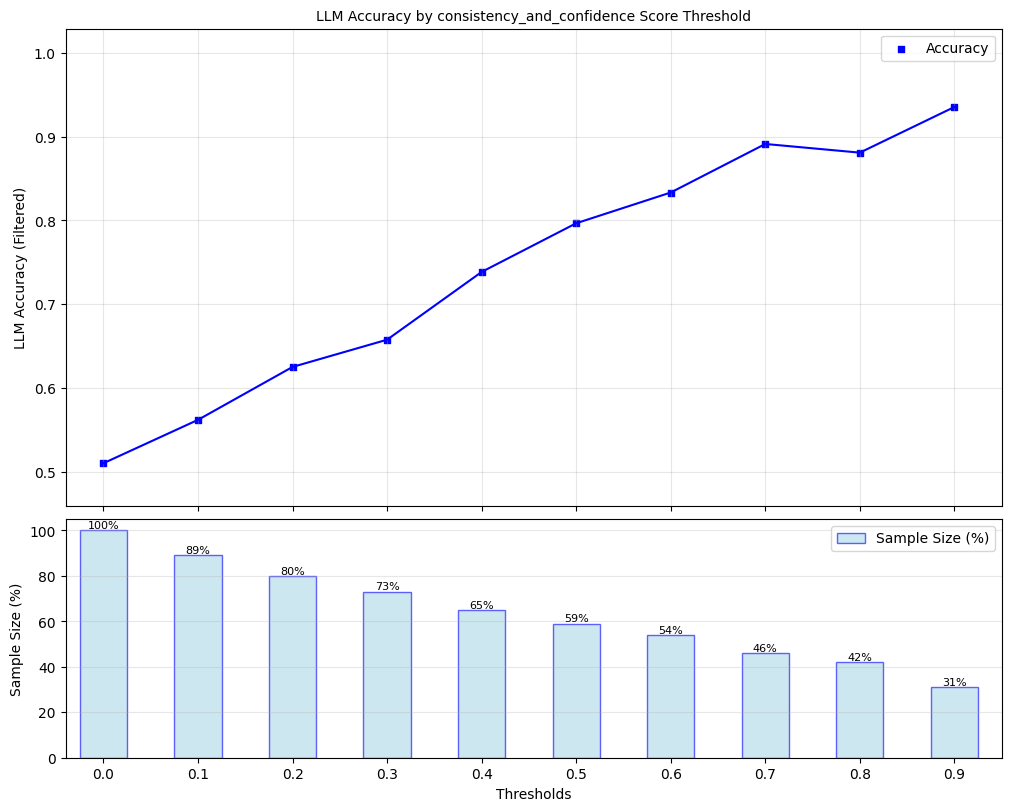

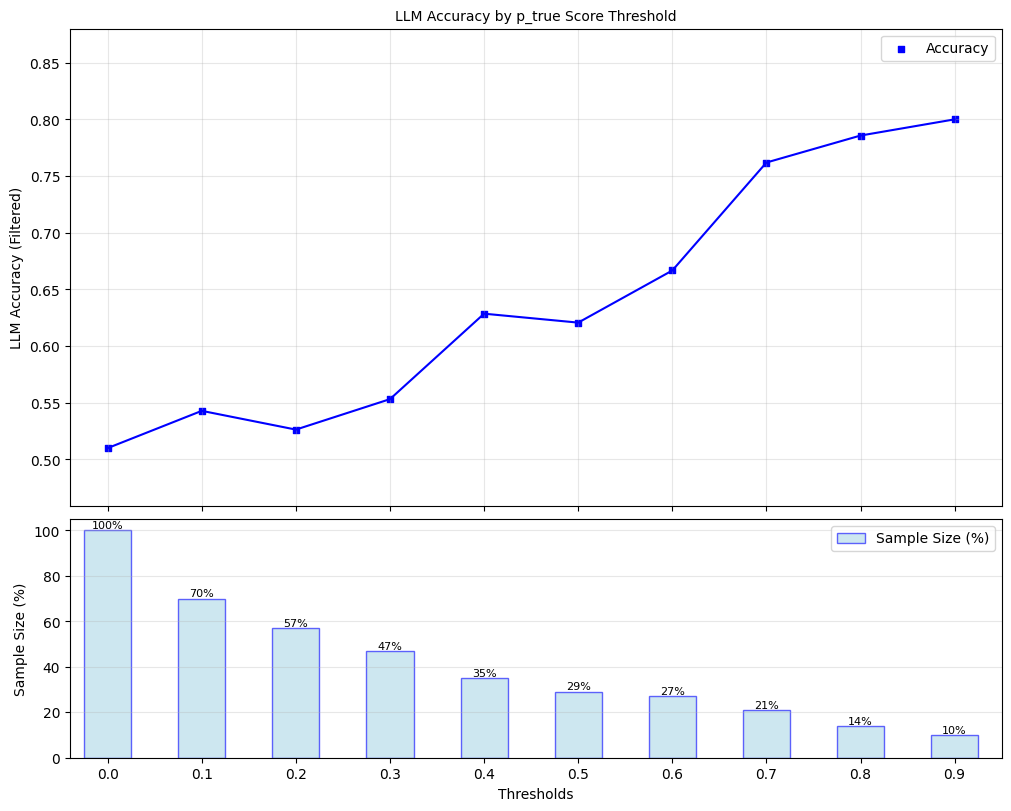

In [11]:
for scorer in ["monte_carlo_probability", "consistency_and_confidence", "p_true"
]:
    plot_model_accuracies(scores=result_df[scorer], correct_indicators=result_df.response_correct, title=f"LLM Accuracy by {scorer} Score Threshold", display_percentage=True)

#### 3.2 Precision, Recall, F1-Score of Hallucination Detection

Lastly, we compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we compute precision, recall, and F1-score for black box scorer predictions of whether responses are correct.

In [12]:
# instantiate UQLM tuner object for threshold selection
split = len(result_df) // 2
t = Tuner()

correct_indicators = (result_df.response_correct) * 1  # Whether responses is actually correct
metric_values = {"Precision": [], "Recall": [], "F1-score": []}
optimal_thresholds = []
for confidence_score in wbuq.scorers:
    # tune threshold on first half
    y_scores = result_df[confidence_score]
    y_scores_tune = y_scores[0:split]
    y_true_tune = correct_indicators[0:split]
    best_threshold = t.tune_threshold(y_scores=y_scores_tune, correct_indicators=y_true_tune, thresh_objective="fbeta_score")

    y_pred = [(s > best_threshold) * 1 for s in y_scores]  # predicts whether response is correct based on confidence score
    optimal_thresholds.append(best_threshold)

    # evaluate on last half
    y_true_eval = correct_indicators[split:]
    y_pred_eval = y_pred[split:]
    metric_values["Precision"].append(precision_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["Recall"].append(recall_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["F1-score"].append(f1_score(y_true=y_true_eval, y_pred=y_pred_eval))

# print results
header = f"{'Metrics':<30}" + "".join([f"{scorer_name:<30}" for scorer_name in wbuq.scorers])
print("=" * len(header) + "\n" + header + "\n" + "-" * len(header))
for metric in metric_values.keys():
    print(f"{metric:<30}" + "".join([f"{round(x_, 3):<30}" for x_ in metric_values[metric]]))
print("-" * len(header))
print(f"{'F-1 optimal threshold':<30}" + "".join([f"{round(x_, 3):<30}" for x_ in optimal_thresholds]))
print("=" * len(header))

Metrics                       monte_carlo_probability       consistency_and_confidence    p_true                        
------------------------------------------------------------------------------------------------------------------------
Precision                     0.667                         0.759                         0.489                         
Recall                        0.917                         0.917                         0.958                         
F1-score                      0.772                         0.83                          0.648                         
------------------------------------------------------------------------------------------------------------------------
F-1 optimal threshold         0.43                          0.52                          0.01                          


<a id='section4'></a>
## 4. Scorer Definitions
White-box UQ scorers leverage token probabilities of the LLM's generated response to quantify uncertainty. All scorers have outputs ranging from 0 to 1, with higher values indicating higher confidence. We define several multi-generation white-box UQ scorers below. 

Let the tokenization LLM response $y_i$ be denoted as $\{t_1,...,t_{L_i}\}$, where $L_i$ denotes the number of tokens the response. Further, let $y_1,...,y_m$ denote $m$ sampled responses generated from the same prompt.

### Monte Carlo Sequence Probability (`monte_carlo_probability`)
Monte Carlo Sequence Probability (MCSP) computes the normalized sequence probability using sampled responses. This is obtained by exponentiating the average log-token-probability across sampled responses. 

\begin{equation}
    MCSP(y_1,y_2,...,y_m) = \exp\{\frac{ \sum_{i=1}^m \sum_{t \in y_i}  \log p_t }{\sum_{i=1}^m L_i}  \}
\end{equation}

For more on this scorer, refer to [Kuhn et al., 2023](https://arxiv.org/abs/2302.09664).


### Consistency and Confidence (CoCoA) (`consistency_and_confidence`)
Consistency and Confidence (CoCoA) leverages two distinct signals: 1) similarity between an original response $y_0$ and a set of sampled responses $y_1,...,y_m$ and token probabilities from the original response $y_0$. 

We first get the length-normalized token probability of our original response:
\begin{equation}
    LNTP(y_0) = \prod_{t \in y_0}  p_t^{\frac{1}{L_0}}.
\end{equation}

We then obtain average cosine similarity across pairings of the original response with all sampled responses, normalized to a [0,1] scale:

\begin{equation}
    NCS(y_0; y_1,...,y_m) = \frac{1}{m} \sum_{i=1}^m \frac{\cos(y_0; y_i) + 1}{2}.
\end{equation}

CoCoa is then calculated as the product of these two terms.

\begin{equation}
    CoCoA(y_0; y_1,...,y_m) = LNTP(y_0) * NCS(y_0; y_1,...,y_m).
\end{equation}

For more on this scorer, refer to [Vashurin et al., 2025](https://arxiv.org/abs/2502.04964).

© 2025 CVS Health and/or one of its affiliates. All rights reserved.